## Логистическая регрессия и SVM

#### План:
1. Логистическая регрессия
2. SVM.
3. Ирисы Фишера. Свойства логистической регрессии и SVM
4. Логистическая регрессия и SVM на менее приятных данных.
5. Метрики классификации
6. ROC-кривая. 
7. Бонус: вывод логистической регрессии через правдоподобие
---

<b>Вступление:</b>
Сегодня мы познакомимся с логистической регрессией узнаем её особенности во время обучения, сравним с SVM и обобщим задачу оптимизации внутри SVM  с целью замены ядровой функции. Так же поговорим про метрики классификации и обсудим как их выбирать 


### Логистическая регрессия

Напомним, что мы по-прежнему решаем задачу бинарной классификации, в которой целевая переменная $y$ принимает два значения: -1 и 1. На прошлом семинаре мы обсудили, что эту задачу можно решить при помощи линейного классификатора 

$$
f(x_i, w) = \mathrm{sign}\left(\langle x_i, w \rangle\right).
$$

Функция потерь для такой задачи – это сумма индикаторов того, что предсказание сделано неверно: 

$$Q(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}[y_i \ne \mathrm{sign}\left(\langle x_i, w \rangle\right)].$$

На лекциях мы обсуждали, что эту идею можно удобно записать через функцию отступа:

$$
Q(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}[y_i \langle x_i, w \rangle < 0].
$$

Такую функцию проблематично дифференцировать по $w$, потому что даже в местах, где градиент существует, он равен нулю. Вместо этого будем минимизировать некоторую функцию $\tilde{Q}(X, w)$, являющуюся верхней оценкой для $Q(X, w)$, и надеяться, что минимизация $\tilde{Q}(X, w)$ позволит достаточно хорошо минимизировать и $Q(X, w)$.

Логистическая регрессия предлагает использовать логистическую функцию потерь:

$$
\tilde{Q}(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}\log(1 + e^{-y_i \langle x_i, w \rangle}) \rightarrow \min_w.
$$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

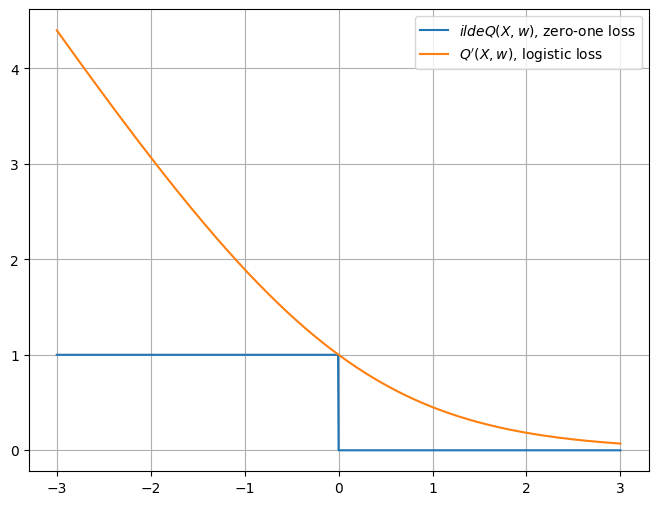

In [ ]:
x = np.concatenate((np.linspace(-3, 0, 500), np.linspace(0, 3, 500)))
np.random.seed(123)
y = np.ones(1000)
w = np.ones(1000)
M = y * x * w

plt.figure(figsize = (8, 6))
plt.plot(x * w, x < 0, label = "$\tilde{Q}(X, w)$, zero-one loss")
plt.plot(M, np.log2(1 + np.exp(-M)), label = "$Q'(X, w)$, logistic loss")
plt.grid()
plt.legend();

Для получения классической задачи логистической регрессии остаётся сделать один шаг и немного изменить постановку задачи. Предположим, что мы хотим решать задачу **мягкой** классификации, то есть предсказывать не метку класса, а вероятность того, что наблюдение принадлежит к классу. Понятно, что мы всегда можем перейти от мягкой классификации к жёсткой, выбрав порог принадлежности к положительному классу. 

**Задание 1.** Поясните, почему для решения задачи мягкой классификации классификатор $f(x_i, w) = \left(\langle x_i, w \rangle\right)$ – не лучший выбор. 

**Ответ:**

Полученное скалярное произведение необязательно будет лежать в отрезке $[0, 1]$.

Мы можем решить названную проблему, подставив $\left(\langle x_i, w \rangle\right)$ в некоторую функцию, областью значений которой является промежуток от 0 до 1. В логистической регрессии такой функцией выступает **сигмоида**:

$$
\sigma(x) = \dfrac{e^x}{1 + e^x} = \dfrac{1}{1 + e^{-x}}.
$$

**Задание 2.** Сигмоида обаладет замечательнеым свойством, которое значительно упрощает вычисление градиентов при градиентном спуске:

$$
\sigma(x)'_x = \sigma(x)(1 - \sigma(x)). 
$$

Покажите, что это действительно так.

**Решение:**

$$
\sigma(x)' = \frac{e^x(1 + e^x) - e^{2x}}{(1 + e^x)^2} = \frac{e^x}{1 + e^x}\frac{1}{1 + e^x} = \sigma(x)(1-\sigma(x)).
$$

Путём хитрых математических преобразований можно показать, что при использовании сигмоиды (= при решении задачи мягкой классификации) $\tilde{Q}(X, w)$ можно записать в следующем виде:

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle)
$$

Эта функция называется log-loss или кросс-энтропией между истинной целевой переменной и предсказанными вероятностями.

**А почему? А потому:**

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle) =\\
$$
$$
=-\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\left(\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right) + [y_i = -1](\log\left(1-\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right)) =\\
$$
$$
=-\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\left(\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right) + [y_i = -1](\log\left(\frac{1}{1 + e^{\langle x_i, w\rangle}}\right)) =\\
$$
$$
=\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log(1 + e^{-\langle x_i, w \rangle}) + [y_i = -1]\log(1 + e^{\langle x_i, w \rangle}) =\\
$$
$$
=\frac{1}{\ell} \sum_{i=1}^{\ell}\log(1 + e^{-y_i\langle x_i, w\rangle}) = \tilde{Q}(X, w)
$$

Регуляризация вводится таким же образом, как это было в случае линейной регрессии. Например, функция потерь для $\ell$-$2$ регуляризации выглядит так:

$$
\tilde{Q}_{reg}(X, w) = \tilde{Q}(X, w) + \frac{1}{2}\lambda\|w\|^2_2.
$$

**Саммари по логистической регрессии:**

- Данные: $y_i \in \{-1, 1\}$, $X$

- Предсказания:

    - По умолчанию предсказывает вероятности:
    $$
    \hat{p}_i = \sigma(\langle x_i, w\rangle) = \frac{1}{1 + e^{-\langle x_i, w\rangle}}
    $$
    
    - Если хотим перейти к метке, то сравниваем вероятность с порогом $t$:
    
    $$
    \hat{y}_i = \begin{cases}
    1,&\text{ если } \hat{p}_i > t,\\
    -1,&\text{ иначе.}
    \end{cases}
    $$
    
- Обучение: 

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle) \to \min_w
$$

### Метод опорных векторов (SVM)

Метод опорных векторов – математически строго обоснованный метод, идея которого состоит в максимизации ширины разделяющей полосы между классами. Так как для подробного вывода SVM требуется уверенное владение методами квадратичной оптимизации, мы разберём только идею и практическую реализацию метода. 

Мы по-прежнему решаем задачу бинарной классификации и используем классификатор $f(x_i, w) = \mathrm{sign}(\langle x_i, w\rangle)$. Предположим, что мы работаем с линейно разделимой выборкой. Определим отступ как минимальное расстояние от точек выборки до разделяющей поверхности классификатора:
$$
\rho(x_i, \langle x, w\rangle) =  \min_i\dfrac{|{\langle x_i, w\rangle|}}{\|w\|}
$$

Задача состоит в том, чтобы максимизировать этот отступ:

$$
\rho(x_i, \langle x, w\rangle) =  \min_i\dfrac{|{\langle x_i, w\rangle|}}{\|w\|} \to \max_w.
$$

Воспользуемся картинкой из Википедии, чтобы лучше понять эту идею:

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" alt="drawing" width="400"/>](https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:SVM_margin.png)

Заметим, что при делении весов на положительное число ответы классификатора не меняются (веса просто пропорционально прошкалируются). Поделим все веса на 

$$\min_i |\langle x_i, w\rangle| > 0.$$ 

Тогда будет верно, что $\min_i |\langle x_i, w\rangle| = 1$, а значит отступ можно переписать как

$$
\rho(\langle x_i, w\rangle) = \frac{1}{\|w\|}.
$$

Получаем задачу SVM в линейно-разделимом случае:

$$
\begin{cases}
\|w\|^2 \to \min_{w}, \\
y_i(\langle x_i, w\rangle) \ge 1, \\
\end{cases}
$$

Если выборка не является линейно-разделимой, то нам придётся позволить линейному классификатору допускать ошибки на некоторых наблюдениях. Тогда задача превращается в поиск оптимального выбора между максимизацией ширины разделяющей полосы и ошибок классификации:

$$
\begin{cases}
\|w\|^2 + C \sum_{i = 1}^{\ell} \xi_i \to \min_{w, \xi_i}, \\
y_i(\langle x_i, w\rangle) \ge 1 - \xi_i, \\
\xi_i \ge 0
\end{cases}
$$

$C$ – параметр, который позволяет регулировать пропорции этого выбора. Чем больше $C$, тем больше штраф за неверную классификацию.

[<img src="https://miro.medium.com/max/1400/1*0vOVPBmYCkw-sUt77HtyGA.png" alt="drawing" width="800"/>](https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496)

Путём хитрых математических преобразований (объединив ограничения) можно показать, что итоговая функция потерь SVM выглядит следующим образом:

$$
Q(X, w) = C\sum_{i=1}^{l} \max\{0, 1 - y_i(\langle x_i, w\rangle)\} + \|w\|^2 \to \min_w
$$

### Ирисы Фишера. Свойства логистической регрессии и SVM

Рассмотрим свойства логистической регрессии и метода опорных векторов на примере классического набора данных ["Ирисы Фишера"](https://ru.wikipedia.org/wiki/Ирисы_Фишера). Этот набор состоит из 150 наблюдений, каждое из которых представляет собой четыре измерения: длина наружной доли околоцветника (`sepal length`), ширина наружной доли околоцветника (`sepal width`), длина внутренней доли околоцветника (`petal length`), ширина внутренней доли околоцветника (`petal width`). Каждое наблюдение относится к одному из трёх классов ириса: `setosa`, `versicolor` или `virginica`. Задача состоит в том, чтобы по измерениям предсказать класс цветка. 

[<img src="https://miro.medium.com/v2/resize:fit:1000/1*Hh53mOF4Xy4eORjLilKOwA.png" alt="drawing" width="800"/>](https://miro.medium.com/max/1000/1*Hh53mOF4Xy4eORjLilKOwA.png)

In [ ]:
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
data['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

**Задание 1.** Перейдём к задаче бинарной классификации: будем предсказывать принадлежность цветка к виду `versicolor` против принадлежности ко всем прочим видам. Перекодируйте зависимую переменную так, чтобы цветки вида `versicolor` имели метку 1, а прочих видов – метку -1. 

In [ ]:
y[y != 1] = -1

**Задание 2**. Будем работать с двумя признаками: `sepal length (cm)` и `sepal width (cm)`. Отделите их в отдельную матрицу. Разделите выборку на обучающую и тестовую, долю тестовой выборки укажите равной 0.3. Отмасштабируйте выборки при помощи StandardScaler. Постройте диаграмму рассеяния по тренировочной выборке и убедитесь, что данные линейно не разделимы. 

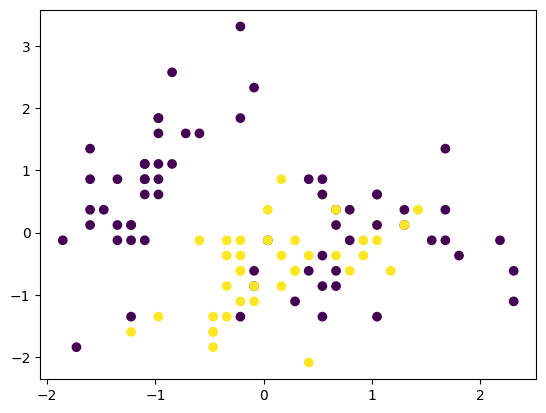

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(123)

X = X[['sepal length (cm)', 'sepal width (cm)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Отмасштабируйте признаки
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)

**Задание 3.** Обучите логистическую регрессию и **SVM с линейным ядром** на тренировочной выборке и убедитесь, что полученные оценки весов действительно различаются. Убедитесь, что `accuracy`, возможно, не подходит в качестве метрики для данной задачи и рассчитайте `f1-меру` на тестовой выборке. Какой алгорим показал более высокое качество?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
lr = LogisticRegression()
svm = SVC(kernel = 'linear')

# Обучите логистическую регрессию и SVM
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)

with np.printoptions(precision=6, suppress=True):
    print("lr:", lr.coef_)
    print("svm:", svm.coef_)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

from scipy import stats

In [ ]:
print("lr accuracy_score:", accuracy_score(y_test, lr.predict(X_test)))
print("svm accuracy_score:", accuracy_score(y_test, svm.predict(X_test)))

lr accuracy_score: 0.8444444444444444
svm accuracy_score: 0.9111111111111111


In [ ]:
print("base accuracy_score", accuracy_score(y_test, np.full(y_test.shape, stats.mode(y_test).mode[0])))

base accuracy_score 0.7777777777777778


<ipython-input-42-545112ae3487>:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("base accuracy_score", accuracy_score(y_test, np.full(y_test.shape, stats.mode(y_test).mode[0])))


In [ ]:
print("lr f1_score:", f1_score(y_test, lr.predict(X_test)))
print("svm f1_score:", f1_score(y_test, svm.predict(X_test)))

lr f1_score: 0.6956521739130435
svm f1_score: 0.8000000000000002


In [ ]:
print("base f1_score", f1_score(y_test, np.full(y_test.shape, stats.mode(y_test).mode[0])))

base f1_score 0.0


<ipython-input-45-06cc7b373f01>:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("base f1_score", f1_score(y_test, np.full(y_test.shape, stats.mode(y_test).mode[0])))


Теперь посмотрим, как различаются решающие поверхности алгоритмов. 

Код ниже построит решающие поверхности для классификаторов. Чтобы он заработал, нужно обязательно сделать `fit` для `lr` и `svm` выше.

In [ ]:
# !pip install mlxtend

# В Колабе, возможно
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import itertools

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

gs = gridspec.GridSpec(1, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'SVM']
for clf, lab, grd in zip([lr, svm],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = np.array(X_train), y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

Теперь изучим свойства каждого классификатора по-отдельности. Начнём с логистической регрессии.

**Задание 3.** Обучите три различные логистические регрессии с разным параметром регуляризации $\alpha$ (обратите внимание, что в реализации `sklearn` $C = 1/\alpha$). Как изменяется разделяющая поверхность в зависимости от $\alpha$?

In [ ]:
lr1 = LogisticRegression(C = 0.01)
lr2 = LogisticRegression(C = 0.05)
lr3 = LogisticRegression(C = 10)

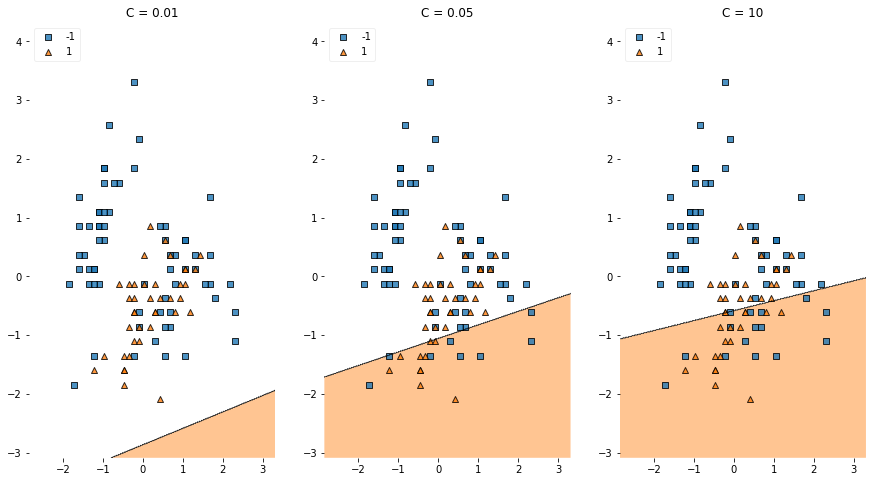

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15,8))

labels = ['C = 0.01', 'C = 0.05', 'C = 10']
for clf, lab, grd in zip([lr1, lr2, lr3],
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X_train, y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

Перейдём к SVM.

**Задание 4.** Обучите три SVM с линейным ядром с разным параметром регуляризации $C$. Как изменяется разделяющая поверхность в зависимости от $C$?

In [ ]:
svc1 = SVC(C = 0.04, kernel = 'linear')
svc2 = SVC(C = 1, kernel = 'linear')
svc3 = SVC(C = 10, kernel = 'linear')

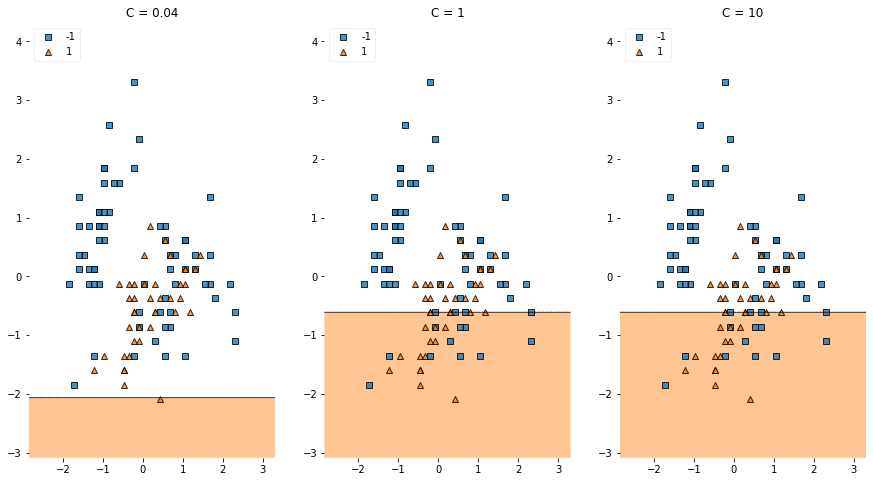

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15,8))

labels = ['C = 0.04', 'C = 1', 'C = 10']
for clf, lab, grd in zip([svc1, svc2, svc3],
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X_train, y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

### Логистическая регрессия и SVM на менее приятных данных (если есть время)

Мы будем работать с [набором данных](https://www.kaggle.com/piyushgoyal443/red-wine-dataset?select=wineQualityReds.csv), содержащим информацию о характеристиках вина. Каждое наблюдение принадлежит к одному из 10 категорий качества вина, и наша задача заключается в том, что предсказать эту категорию. 

In [ ]:
data = pd.read_csv('wineQualityReds.csv', index_col = 0)
data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Как указано в описании набора, в нём нет пропущенных значений, и все переменные являются непрерывными. Целевая переменная – `quality`. 

**Задание 1.** Перейдём к задаче бинарной классификации и будем предсказывать только наиболее популярную категорию качества. Закодируйте столбец `quality` так, чтобы наиболее частая категория (это категория 5) получила метку 1, а все прочие категории – метку -1.

In [ ]:
data.loc[data["quality"] != 5, "quality"] = -1
data.loc[data["quality"] == 5, "quality"] = 1
data

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
2,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1
3,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1
4,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,-1
5,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1
1596,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,-1
1597,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,-1
1598,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,1


**Задание 2.** Разделите признаки и целевую переменную. Разделите выборку на тренировочную и тестовую, долю тестовой выборки укажите равной 0.3. При помощи `StandardScaler` отмасштабируйте тренировочную и тестовую выборки. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Отмасштабируйте признаки
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

**Задание 3.** При помощи кросс-валидации (параметры выберите сами) подберите оптимальные значения коэффициентов регуляризации для логистической регрессии и SVM с линейным ядром. Обучите модели с этими параметрами. Убедитесь, что доля правильных ответов – не лучший вариант для нашей задачи и рассчитайте F-меру на тестовой выборке. Какой алгоритм показал себя лучше? 

 **Бонус для самых отважных:** качество работы SVM можно улучшить за счёт применения ядер, после чего разделяющая поверхность становится нелинейной. Если вам интересно, попросите семинариста рассказать об этом подробнее.  

In [ ]:
from sklearn.model_selection import cross_validate

scores_lr = []
scores_svm = []

for c in np.arange(0.1, 10, 1):
    lr = LogisticRegression(C = c)
    svm = SVC(C = c)
    pass

## Метрики классификации 

<img src="https://image.jimcdn.com/app/cms/image/transf/dimension=1920x10000:format=png/path/s8ff3310143614e07/image/iab2d53abc26a2bc7/version/1549760945/image.png" width=120%>

**Accuracy score** - доля правильно классифицированных объектов.

**Recall** (или **Sensitivity**) - доля объектов положительного класса из всех объектов положительного класса, которую наша модель правильно детектирует.

**Precision** - доля объектов, которые модель классифицирует как положительные и при этом действительно являющихся положительными.

**F1 score** - гармоническое среднее между **Precision** и **Recall** 

$$F_{1} score = 2\frac{Precision \cdot Recall}{Precision + Recall}$$

**$F_{\beta}$ score** - обобщение F1 score: исполользуем в случаях, когда важнее выдерживать либо точность, либо полноту

$$F_{\beta} score = (1 + \beta^2)\frac{Precision \cdot Recall}{\beta^2 Precision + Recall}$$

In [ ]:
n = 500
# True labels
y = np.random.randint(0, 2, 500)
# Predicted labels
p = (np.random.random(500)>0.5).astype(int)

In [ ]:
def accuracy(y, p):
    return sum(y==p)/len(y)

def precision(y, p):
    (TN, FP), (FN, TP) = confusion_matrix(y, p)
    
    return TP/(TP+FN)
    
def recall(y, p):
    (TN, FP), (FN, TP) = confusion_matrix(y, p)
    
    return TP/(TP+FP)
    
def f1(y, p, beta=1):
    re = recall(y, p)
    pr = precision(y, p)
    
    return (1+beta**2)*pr*re/(beta**2*pr+re) 

In [ ]:
metric_dict = {'acc':accuracy, 'pr':precision, 're':recall, 'f1':f1}
for title, func in metric_dict.items():
    print(title, func(y, p))

acc 0.504
pr 0.5298507462686567
re 0.5378787878787878
f1 0.5338345864661654


In [ ]:
print(classification_report(y, p))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       232
           1       0.54      0.53      0.53       268

    accuracy                           0.50       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.50      0.50      0.50       500



### ROC-кривая



Определим следующие величины:

$$
TPR \text{ (true positive rate, recall, sensitivity)} = \dfrac{TP}{TP + FN}
$$
– доля правильно предсказанных объектов положительного класса.

$$
FPR \text{ (false positive rate, 1 - specificity)} = \dfrac{FP}{FP + TN}
$$
– доля неправильно предсказанных объектов отрицательного класса.

Рассмотрим задачу мягкой классификации: мы предказываем вероятности принадлежности наблюдения к положительному и отрицательному классам. Тогда TPR и FPR будут зависеть от порога для вероятности, выше которого наблюдение будет отнесено к положительному классу. ROC-кривая строится в координатах $(FPR, TPR)$ и показывает комбинации TPR и FPR при всевозможных значениях порога. 

Для хорошего классификатора эта кривая является вогнутой, а для идеального классификатора она будет проходить через точку $(0, 1)$ (почему?).

[<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png" alt="drawing" width="350"/>](https://ru.wikipedia.org/wiki/ROC-кривая)



**Задание 1.** Постройте ROC-кривую для следующей выборки.

In [ ]:
# True labels
y = [-1, 1, 1, -1, 1, 1]
# Predicted labels
p = [0.5, 0.1, 0.2, 0.9, 0.7, 0.1]

**Решение:**
1. Упорядочим наблюдения по **убыванию** ответов алгоритма.

In [ ]:
y = [-1, 1, -1, 1, 1, 1]
p = [0.9, 0.7, 0.5, 0.2, 0.1, 0.1]

2. Разобьём единичный квадрат на $(m, n)$ частей, где $m$ – число 1 в $y$, $n$ – число нулей. Стартуем из точки $(0, 0)$. Если значение $y$ равно 1, делаем шаг вверх, а если -1 – вправо. Понятно, что конечная точка нашего маршрута – точка $(1, 1)$.

**Важный момент:** если у нескольких объектов значения предсказаний равны, а $y$ – различны, то мы должны сделать ход "по диагонали". 

Если построить кривую по этому алгоритму, то получим:

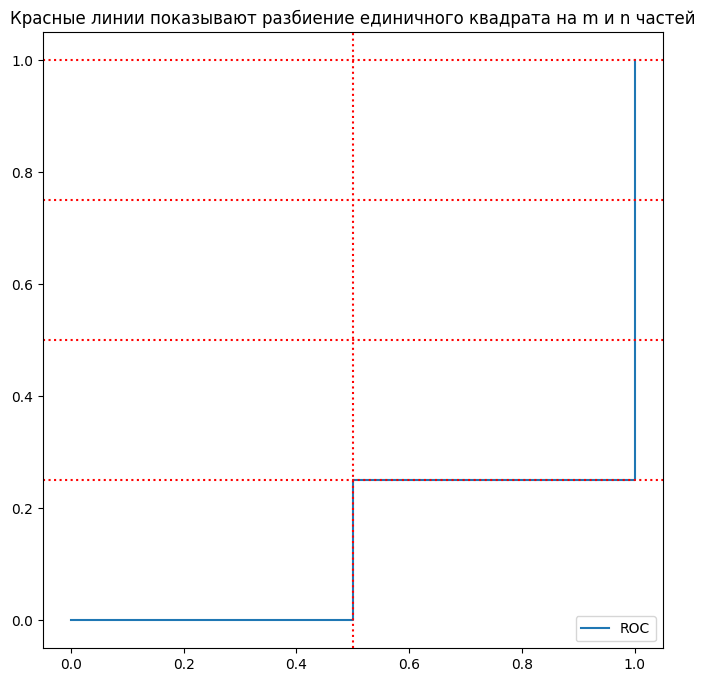

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y, p)

plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC')
plt.axvline(0.5, linestyle = 'dotted', c = 'red')
plt.axhline(0.25, linestyle = 'dotted', c = 'red')
plt.axhline(0.5, linestyle = 'dotted', c = 'red')
plt.axhline(0.75, linestyle = 'dotted', c = 'red')
plt.axhline(1.0, linestyle = 'dotted', c = 'red')
plt.title('Красные линии показывают разбиение единичного квадрата на m и n частей')
plt.legend()

3. Полученная кривая и является ROC-кривой. 

**(Почему этот алгоритм имеет смысл?)**

**Пример с диагональным шагом.**

In [ ]:
p = [0.5, 0.1, 0.2, 0.6, 0.2, 0.3, 0.0]
y = [-1,  -1,   -1, 1,    1,   1,   -1]

In [ ]:
fpr, tpr, _ = roc_curve(y, p)

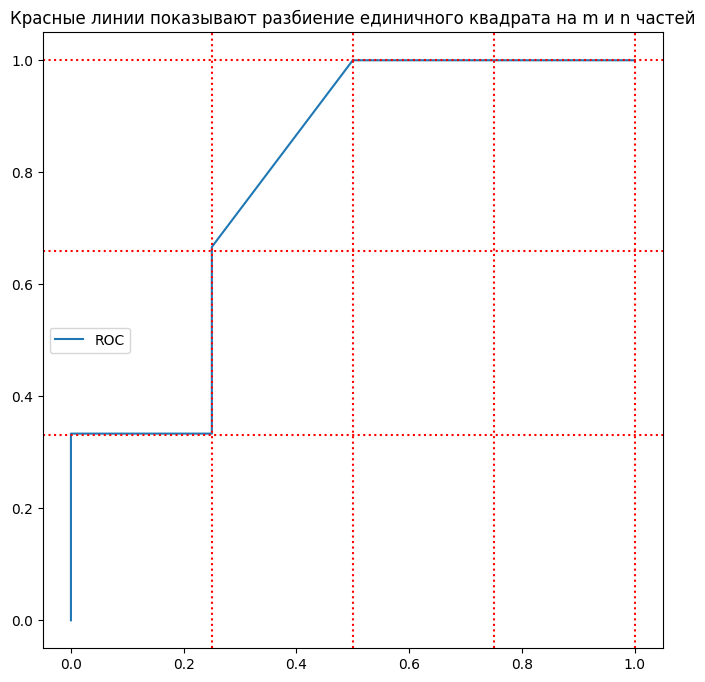

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC')
plt.axvline(0.25, linestyle = 'dotted', c = 'red')
plt.axvline(0.5, linestyle = 'dotted', c = 'red')
plt.axvline(0.75, linestyle = 'dotted', c = 'red')
plt.axvline(1.0, linestyle = 'dotted', c = 'red')
plt.axhline(0.33, linestyle = 'dotted', c = 'red')
plt.axhline(0.66, linestyle = 'dotted', c = 'red')
plt.axhline(1.0, linestyle = 'dotted', c = 'red')
plt.title('Красные линии показывают разбиение единичного квадрата на m и n частей')
plt.legend()

**Задание 2.** ROC AUC – площадь под ROC-кривой – равна доле пар наблюдений $(y = 1, y = -1)$, которые алгоритм верно упорядочил. Таким образом, чем больше ROC AUC, тем качественнее отработал классификатор. Вычислите ROC AUC для построенной ROC-кривой из первого примера. 

**Решение:**

In [ ]:
0.25 * 0.5

0.125

**Задание 3.** Как выглядит ROC-кривая для случайного классификатора? 


**Задание 4.** Как по ROC-кривой выбрать порог для бинаризации?

В `sklearn` реализовано вычисление значений ROC-кривой и площади под ней. 

In [ ]:
from sklearn.metrics import roc_curve, auc

**Важно:** в `roc_curve` передаются предсказанные вероятности!

### Бонус для самых смелых: вывод логистической регрессии через правдоподобие

Перекодируем $y$ так, что её возможные значения – это 0 и 1. Теперь $y$ является случайной величиной из распределения Бернулли. Тогда сигмоида задаёт условную вероятность принадлежности $y$ к положительному классу:

$$
P(y_i = 1 | x_i, w) = \sigma(x_i, w).
$$

Будем искать оценку коэффициентов $w$ при помощи метода максимального правдоподобия.

$$
\mathcal{L} = \sigma(x_i, w)^{\sum_i y_i}(1 - \sigma(x_i, w))^{\sum_i 1 - y_i}
$$

Логарифмируем:

$$
\mathcal{l} = \sum_i y_i \log\sigma(x_i, w) + (1 - y_i)(1 - \log\sigma(x_i, w))
$$

Если теперь взять среднее, то мы получим log-loss, взятый со знаком минус. Таким образом, минимизация функции потерь в логистической регрессии эквивалентна  максимизации правдоподобия в задаче нахождения оценок $w$!